In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import hashlib
import math, os
from tqdm import tqdm

C:\Users\taker\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pd.set_option('display.max_columns', 40)

In [3]:
# トレーニング用の入力データの選択
X_columns = ['locality', 'age', 'rank', 'leg', 'racing piont', \
             'S', 'B', 'Nige', 'Maki', 'Sashi', 'Ma', \
             '1st', '2nd', '3rd', 'Chakugai', 'win', '2ren', '3ren']


In [4]:
# Webスクレイピングで取得した戦績データをファイルから読み取り、データフレームに変換＋データ前処理
def get_df_train(places):
    
    init_flag = True
    for place in places:
        print('loading data for ' + place)
        filename = "data/" + place + "_train_data.csv"
        df_train = pd.read_csv(filename, encoding="SHIFT_JIS", header=0, nrows=None)

        targets = []
        name_ids = []
        localities = []

        for index, row in df_train.iterrows():

            # 1位を予想するため One-Hot表現にする
            result = row['result']
            if result == 1:
                target = 1
            else:
                target = 0
            targets.append(target)    

            # 名前をハッシュを使ってID化
            name = row['name']
            name_hash = hashlib.md5(name.encode()).hexdigest()
            name_id = name_hash[-8:]
            name_ids.append(name_id)

            # 　ランクの例外処理
            if row['rank'] == 'SS':
                df_train.loc[index, 'rank'] = '0'
            elif row['rank'] == 'L1':
                df_train.loc[index, 'rank'] = '6'

            # 出身地を地区毎にグループ化
            prefecture = row['prefecture']
            if prefecture in {'1', '2', '3', '5'}:
                locality = '1' #北東北
            elif prefecture in {'4', '6', '7'}:
                locality = '2' #南東北
            elif prefecture in {'8', '9'}:
                locality = '3' #茨栃
            elif prefecture in {'11', '13'}:
                locality = '4' #埼京
            elif prefecture in {'10', '15', '19', '20'}:
                locality = '5' #上信越
            elif prefecture in {'12', '14', '22'}:
                locality = '6' #南関東
            elif prefecture in {'16', '17', '21', '23', '24'}:
                locality = '7' #中部
            elif prefecture in {'18', '25', '26', '27', '28', '29', '30'}:
                locality = '8' #近畿
            elif prefecture in {'31', '32', '33', '34', '35'}:
                locality = '9' #中国
            elif prefecture in {'36', '37', '38', '39'}:
                locality = '10' #四国
            elif prefecture in {'40', '41', '42', '43', '44', '45', '46', '47'}:
                locality = '11' #九州
            else:
                locality = '12' #外国

            localities.append(locality)

        # 前処理したデータのデータフレームへの置き換え
        df_train['target'] = targets
        df_train['name_id'] = name_ids
        df_train['locality'] = localities

        # カラムの順番入れ替え（見やすさのため）
        columns = list(df_train.columns)
        columns.remove('name_id')
        columns.insert(columns.index("name") + 1, "name_id")
        columns.remove('locality')
        columns.insert(columns.index("prefecture") + 1, "locality")

        df_train = df_train.loc[:,columns]
        
        if init_flag:
            df_train_concat = df_train
            init_flag = False
        else:
            df_train_concat = pd.concat([df_train_concat, df_train])
    
    return df_train_concat

In [5]:
# Webスクレイピングで取得した戦績データをファイルから読み取り、データフレームに変換＋データ前処理
def get_df_predict(filename):
    
    init_flag = True
    print('loading data for predict')
    df_predict = pd.read_csv(filename, encoding="SHIFT_JIS", header=0, nrows=None)

    display(df_predict)
    targets = []
    name_ids = []
    localities = []

    for index, row in df_predict.iterrows():

        # 名前をハッシュを使ってID化
        name = row['name']
        name_hash = hashlib.md5(name.encode()).hexdigest()
        name_id = name_hash[-8:]
        name_ids.append(name_id)

        # 　ランクの例外処理
        if row['rank'] == 'SS':
            df_predict.loc[index, 'rank'] = '0'
        elif row['rank'] == 'L1':
            df_predict.loc[index, 'rank'] = '6'

        # 出身地を地区毎にグループ化
        prefecture = row['prefecture']
        if prefecture in {'1', '2', '3', '5'}:
            locality = '1' #北東北
        elif prefecture in {'4', '6', '7'}:
            locality = '2' #南東北
        elif prefecture in {'8', '9'}:
            locality = '3' #茨栃
        elif prefecture in {'11', '13'}:
            locality = '4' #埼京
        elif prefecture in {'10', '15', '19', '20'}:
            locality = '5' #上信越
        elif prefecture in {'12', '14', '22'}:
            locality = '6' #南関東
        elif prefecture in {'16', '17', '21', '23', '24'}:
            locality = '7' #中部
        elif prefecture in {'18', '25', '26', '27', '28', '29', '30'}:
            locality = '8' #近畿
        elif prefecture in {'31', '32', '33', '34', '35'}:
            locality = '9' #中国
        elif prefecture in {'36', '37', '38', '39'}:
            locality = '10' #四国
        elif prefecture in {'40', '41', '42', '43', '44', '45', '46', '47'}:
            locality = '11' #九州
        else:
            locality = '12' #外国

        localities.append(locality)

    # 前処理したデータのデータフレームへの置き換え
    df_predict['name_id'] = name_ids
    df_predict['locality'] = localities

    # カラムの順番入れ替え（見やすさのため）
    columns = list(df_predict.columns)
    columns.remove('name_id')
    columns.insert(columns.index("name") + 1, "name_id")
    columns.remove('locality')
    columns.insert(columns.index("prefecture") + 1, "locality")

    df_predict = df_predict.loc[:,columns]

    return df_predict

In [6]:
def get_train_test_data(df_train):
    X = []
    target = []
        
    # 各レース毎に
    grouped = df_train.groupby(['date', 'place', 'race_num'])
    for race_name, group in tqdm(grouped):
        #print(race_name)
        racer_count = group.shape[0]
        # もし、９輪ではないレースは、トレーニングの対象から外す（モデルを固めるため）
        if racer_count != 9:
            continue
        X.append(group[X_columns].values)
        target.append(group['target'].values)

    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    d_ = np.array(target)

    X_train, X_test, d_train, d_test = train_test_split(X, d_, test_size = 0.2)

    return X_train, X_test, d_train, d_test


In [7]:
def get_predict_data(df_predict):
    X = []
        
    # 各レース毎に
    grouped = df_predict.groupby(['date', 'place', 'race_num'])
    for race_name, group in tqdm(grouped):
        #print(race_name)
        racer_count = group.shape[0]
        # もし、９輪ではないレースは、トレーニングの対象から外す（モデルを固めるため）
        if racer_count != 9:
            continue
        X.append(group[X_columns].values)

    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

    return X

In [8]:
class DNN(object):
    def __init__(self, n_in, n_hiddens, n_out):
        self.n_in = n_in
        self.n_hiddens = n_hiddens
        self.n_out = n_out
        self.weights = []
        self.biases = []

        self._x = None
        self._y = None
        self._t = None
        self._keep_prob = None
        self._sess = None
        self._history = {
            'accuracy': [],
            'loss': []
        }

    def weight_variable(self, shape):
        # He 初期化
        n_sum = 1
        for n in shape:
            n_sum *= n
        stddev = math.sqrt(2.0 / n_sum)
        print('stddev: ', stddev)
        initial = tf.truncated_normal(shape, stddev=stddev)
        return tf.Variable(initial)

    def bias_variable(self, shape):
        initial = tf.zeros(shape)
        return tf.Variable(initial)

    def inference(self, x, keep_prob):
        # 入力層 - 隠れ層、隠れ層 - 隠れ層
        for i, n_hidden in enumerate(self.n_hiddens):
            if i == 0:
                input = x
                input_dim = self.n_in
            else:
                input = output
                input_dim = self.n_hiddens[i-1]

            self.weights.append(self.weight_variable([input_dim, n_hidden]))
            self.biases.append(self.bias_variable([n_hidden]))

            input = tf.layers.batch_normalization(input)
            h = tf.nn.relu(tf.matmul(input, self.weights[-1]) + self.biases[-1])
            output = tf.nn.dropout(h, keep_prob)

        # 隠れ層 - 出力層
        self.weights.append(self.weight_variable([self.n_hiddens[-1], self.n_out]))
        self.biases.append(self.bias_variable([self.n_out]))

        y = tf.nn.softmax(tf.matmul(output, self.weights[-1]) + self.biases[-1])
        
        return y

    def predict(self, X_pred, p_keep=1.0):
        # 予測
        x = tf.placeholder(tf.float32, shape=[None, self.n_in])
        keep_prob = tf.placeholder(tf.float32)
        y_pred = self.inference(x, keep_prob)
        
        sess = tf.Session()
        init = tf.global_variables_initializer()
        sess.run(init)
        
        Y_pred = np.empty((X_pred.shape[0], 9))
        for i in range(len(X_pred)):
            X_ = X_pred[i].reshape(1, X_pred.shape[1])
            prob = y_pred.eval(session=sess, feed_dict={
                x: X_,
                keep_prob: p_keep
            })
            Y_pred[i] = prob
        
        return Y_pred
    
    def loss(self, y, t):
        # クロスエントロピー  Nan 問題回避のためのコードに変更
        #cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(y), axis=1))
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=t, logits=y))
        #return cross_entropy
        # L2 正則化
        l2_decay = 0.0001
        l2_losses = [tf.nn.l2_loss(w) for w in self.weights]
        l2_loss = l2_decay * tf.add_n(l2_losses)
        loss = cross_entropy + l2_loss
        return loss

    def training(self, loss):
        optimizer = tf.train.AdamOptimizer()
        train_step = optimizer.minimize(loss)
        return train_step

    def accuracy(self, y, t):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy

    def fit(self, X_train, Y_train, nb_epoch=100, batch_size=100, p_keep=0.5, verbose=1):
        x = tf.placeholder(tf.float32, shape=[None, self.n_in])
        t = tf.placeholder(tf.float32, shape=[None, self.n_out])
        keep_prob = tf.placeholder(tf.float32)

        self._x = x
        self._t = t
        self._keep_prob = keep_prob

        y = self.inference(x, keep_prob)
        loss = self.loss(y, t)
        train_step = self.training(loss)
        accuracy = self.accuracy(y, t)

        sess = tf.Session()
        
        # TensorBoardで追跡する変数を定義
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', sess.graph)
        
        init = tf.global_variables_initializer()
        sess.run(init)

        writer.close()
        
        self._y = y
        self._sess = sess

        N_train = len(X_train)
        n_batches = N_train // batch_size

        for epoch in range(nb_epoch):
            X_, Y_ = shuffle(X_train, Y_train)

            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size

                sess.run(train_step, feed_dict={
                    x: X_[start:end],
                    t: Y_[start:end],
                    keep_prob: p_keep
                })
            loss_ = loss.eval(session=sess, feed_dict={
                x: X_train,
                t: Y_train,
                keep_prob: 1.0
            })
            accuracy_ = accuracy.eval(session=sess, feed_dict={
                x: X_train,
                t: Y_train,
                keep_prob: 1.0
            })
            self._history['loss'].append(loss_)
            self._history['accuracy'].append(accuracy_)

            if verbose:
                print('epoch:', epoch,
                      ' loss:', loss_,
                      ' accuracy:', accuracy_)

        saver = tf.train.Saver()
        saver.save(sess, "model/training_model")
                
        return self._history

    def evaluate(self, X_test, Y_test):
        accuracy = self.accuracy(self._y, self._t)
        return accuracy.eval(session=self._sess, feed_dict={
            self._x: X_test,
            self._t: Y_test,
            self._keep_prob: 1.0
        })

In [9]:
def plot(history):

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()  # 2つのプロットを関連付ける

    ax1.plot(history['loss'], label='loss', color='orange')
    ax1.set_ylabel('loss')
    ax1.set_ylim(0, 2.5)
    ax1.legend(loc='best', bbox_to_anchor=(1.01, 0.71, 0.322, .100), borderaxespad=0.,)

    ax2.plot(history['accuracy'], label='accuracy', color='dodgerblue')
    ax2.set_ylabel('accuracy')
    ax2.set_ylim(0, 1.0)
    ax2.legend(loc='best', bbox_to_anchor=(1.01, 0.8, 0.4, .100), borderaxespad=0.,)

    plt.show()

In [10]:
places = []
for filename in os.listdir('data/'):
    place = filename.split('_')[0]
    places.append(place)
print(places)

# クロスエントロピーが Nan になる場所を除外 (いわき平、熊本)
places.remove('iwakitaira')
places.remove('kumamoto')

df_train = get_df_train(places)

['aomori', 'beppu', 'chiba', 'fukui', 'gifu', 'hakodate', 'hiratsuka', 'hiroshima', 'hofu', 'ito', 'iwakitaira', 'kawasaki', 'keiokaku', 'kishiwada', 'kochi', 'kokura', 'komatsushima', 'kumamoto', 'kurume', 'maebashi', 'matsudo', 'matsusaka', 'matsuyama', 'mukomachi', 'nagoya', 'nara', 'odawara', 'ogaki', 'omiya', 'sasebo', 'seibuen', 'shizuoka', 'tachikawa', 'takamatsu', 'takeo', 'tamano', 'toride', 'toyama', 'toyohashi', 'utsunomiya', 'wakayama', 'yahiko', 'yokkaichi']
loading data for aomori


C:\Users\taker\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


loading data for beppu
loading data for chiba
loading data for fukui
loading data for gifu
loading data for hakodate
loading data for hiratsuka
loading data for hiroshima
loading data for hofu
loading data for ito
loading data for kawasaki
loading data for keiokaku
loading data for kishiwada


C:\Users\taker\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


loading data for kochi
loading data for kokura
loading data for komatsushima
loading data for kurume
loading data for maebashi
loading data for matsudo
loading data for matsusaka
loading data for matsuyama
loading data for mukomachi


C:\Users\taker\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (9,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


loading data for nagoya
loading data for nara
loading data for odawara
loading data for ogaki
loading data for omiya
loading data for sasebo
loading data for seibuen
loading data for shizuoka
loading data for tachikawa
loading data for takamatsu
loading data for takeo
loading data for tamano
loading data for toride
loading data for toyama
loading data for toyohashi
loading data for utsunomiya
loading data for wakayama


C:\Users\taker\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


loading data for yahiko


C:\Users\taker\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


loading data for yokkaichi


Generating Training/Test Data


100%|████████████████████████████████████████████████████████████████████████| 146536/146536 [01:04<00:00, 2281.56it/s]


Training ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
epoch: 0  loss: 2.0525398  accuracy: 0.31421736
epoch: 1  loss: 2.0556047  accuracy: 0.31462944
epoch: 2  loss: 2.0488565  accuracy: 0.32154205
epoch: 3  loss: 2.05423  accuracy: 0.318551
epoch: 4  loss: 2.0568182  accuracy: 0.3173413
epoch: 5  loss: 2.0540054  accuracy: 0.31945497
epoch: 6  loss: 2.059744  accuracy: 0.31601197
epoch: 7  loss: 2.0545988  accuracy: 0.32158193
epoch: 8  loss: 2.0640607  accuracy: 0.3135261
epoch: 9  loss: 2.0582387  accuracy: 0.31992024
accuracy:  0.31977454


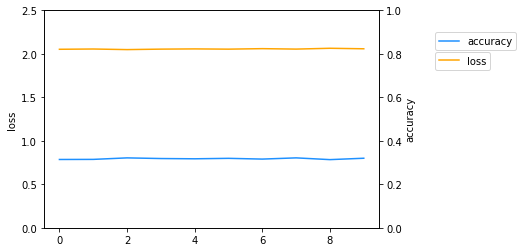

In [11]:
print("Generating Training/Test Data")
X_train, X_test, Y_train, Y_test = get_train_test_data(df_train)

# モデルの定義
model = DNN(n_in = X_train.shape[1], n_hiddens=[256, 256], n_out=9)

print("Training ...")
history = model.fit(X_train, Y_train, nb_epoch = 10, batch_size=32, p_keep=0.5)

accuracy = model.evaluate(X_test, Y_test)
print('accuracy: ', accuracy)
plot(history)


In [19]:
for filename in os.listdir('predict/'):
    df_predict = get_df_predict('predict/' + filename)

loading data for predict


,date,place,race_num,predict,koukiai,evaluation,bracket,car_num,name,prefecture,age,period,rank,leg,gear,racing piont,S,B,Nige,Maki,Sashi,Ma,1st,2nd,3rd,Chakugai,win,2ren,3ren,Unnamed: 29
0,20180927,aomori,1,9.0,NaN,15,1,1,黒田 淳,33,33,97,5,1,3.92,105.06,1,7,2,3,3,1,6,3,6,17,18.7,28.1,46.8,NaN
1,20180927,aomori,1,NaN,NaN,20,2,2,三上 佳孝,12,36,88,4,1,3.85,99.03,2,2,0,2,4,3,2,7,2,22,6.0,27.2,33.3,NaN
2,20180927,aomori,1,5.0,NaN,18,3,3,前田 拓也,27,44,71,5,3,3.86,103.73,0,0,0,0,3,0,2,1,3,13,10.5,15.7,31.5,NaN
3,20180927,aomori,1,4.0,NaN,18,4,4,野口 正則,29,28,105,4,2,3.85,97.93,0,11,1,3,1,0,2,3,1,23,6.8,17.2,20.6,NaN
4,20180927,aomori,1,8.0,NaN,20,4,5,吉永 和生,34,42,80,4,3,3.92,100.37,0,1,0,2,3,2,4,3,2,16,16.0,28.0,36.0,NaN
5,20180927,aomori,1,NaN,NaN,24,5,6,池田 智毅,30,48,68,4,3,3.92,94.72,0,0,0,0,1,1,0,2,2,19,0.0,8.6,17.3,NaN
6,20180927,aomori,1,6.0,NaN,20,5,7,吉田 裕全,11,33,90,4,1,3.92,99.78,3,0,0,0,5,3,5,3,3,21,15.6,25.0,34.3,NaN
7,20180927,aomori,1,NaN,NaN,24,6,8,北浦 和人,14,35,105,4,1,3.92,95.25,0,0,0,0,1,0,0,1,1,10,0.0,8.3,16.6,NaN
8,20180927,aomori,1,7.0,NaN,20,6,9,兵藤 一也,10,40,82,4,3,3.85,100.33,1,0,0,0,2,3,1,4,3,13,4.7,23.8,38.0,NaN
9,20180927,aomori,2,7.0,NaN,19,1,1,松山 桂輔,23,34,88,4,1,3.93,99.19,3,4,1,2,3,2,4,4,4,19,12.9,25.8,38.7,NaN


In [22]:
print("Generating Predict Data")
X_pred = get_predict_data(df_predict)
print(X_pred.shape)


print("Predicting ...")

Y_pred = model.predict(X_pred)

for index in range(len(Y_pred)):
    
    df_ = df_predict.iloc[index * 9, :]
    date = df_['date']
    place = df_['place']
    race_num = df_['race_num']
    
    print(date, place, race_num)
    print(Y_pred[index])




Generating Predict Data


100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 2077.55it/s]


(42, 162)
Predicting ...
stddev:  0.006944444444444444
stddev:  0.005524271728019903
stddev:  0.02946278254943948
20180927 aomori 1
[0.11625174 0.10931846 0.11491615 0.110145   0.1053658  0.1056472
 0.11178203 0.11464614 0.11192749]
20180927 aomori 2
[0.11803754 0.11110927 0.11486871 0.1087623  0.10534856 0.10527037
 0.11124291 0.11450625 0.11085414]
20180927 aomori 3
[0.11508205 0.10978129 0.11324989 0.11094048 0.10494439 0.10517364
 0.11375435 0.11553245 0.11154149]
20180927 aomori 4
[0.11671912 0.10947534 0.11390457 0.10982163 0.10573551 0.10655966
 0.11168691 0.11441965 0.11167761]
20180927 aomori 5
[0.1173529  0.10925984 0.11410996 0.10957707 0.10578035 0.10628208
 0.11101192 0.1153426  0.11128327]
20180927 aomori 6
[0.1172015  0.11016101 0.11525241 0.10856969 0.10568031 0.10670174
 0.11073845 0.11469565 0.1109993 ]
20180927 aomori 7
[0.11622591 0.11045526 0.11396676 0.10985239 0.10562307 0.10578491
 0.11148237 0.11557887 0.11103044]
20180927 aomori 8
[0.11604647 0.10761774 0.1164